In [2]:
import tensorflow as tf
import os
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler



### Import CSV and transform 

In [50]:
df = pd.read_csv("F:\Git\Food-price-forecast\ModelsAndDatasets\Datasets\price_temp_grain_starch.csv")
df = df.drop(columns=["Unnamed: 0"])   #Lösche unnötige Spalte
df.index = pd.to_datetime(df['Date'], format = '%Y-%m') #Datum als Index
df = df[df.Date <= "2021-12-01"]  #Alles vor 2022
df = df.drop(columns=["Date"], axis = 1)
df

,Food_Price,Air_Temperature,grain_starch_output_price
Date,,,
1996-01-01,74.9,-2.82,87.3
1996-02-01,75.5,-2.18,87.4
1996-03-01,76.1,1.00,87.7
1996-04-01,76.4,8.40,87.8
1996-05-01,76.2,11.15,88.8
...,...,...,...
2021-08-01,114.2,16.40,107.2
2021-09-01,114.2,15.16,108.2
2021-10-01,114.2,9.63,112.8


### Plot Food-Price

<Axes: xlabel='Date'>

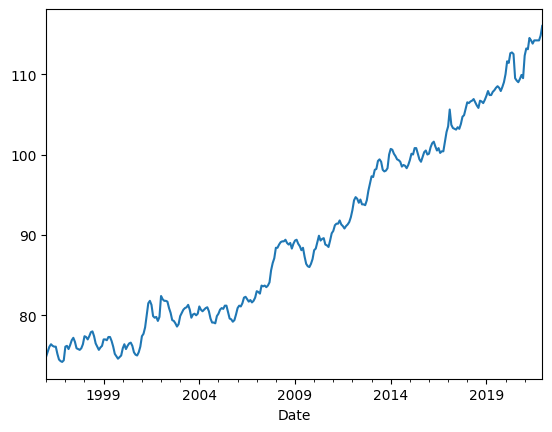

In [51]:
price = df["Food_Price"]
price.plot()


### Erstelle Sliding-Window Arrays

In [138]:
def df_to_X_y(df, window_size=5): #gebe DataFrame und Zeitraum der zu berücksichtigenden Perioden für Vorhersage an 
    df_as_np = df.to_numpy()
    X = [] # Vergangene Werte für Vorhersage
    y = [] # Labels für zu vorhersagende Periode

    for i in range(len(df_as_np)-window_size): #Iteration über numpy-Liste der Werte abzüglich window size
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)          #Gebe Zeitreihe für X und y zurück

#### Überprüfe Format 

In [139]:
window = 9
X, y = df_to_X_y(df, window)
X.shape, y.shape

((303, 9, 3), (303,))

#### Erstelle Test-Train Split

In [160]:
X_train, y_train = X[:250], y[:250]
X_val, y_val = X[250:275], y[250:275]
X_test, y_test = X[275:], y[275:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape  #Überprüfufe Form der Splits

X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_val = np.asarray(X_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

## Model-Definition & Training

### Erstelle LSTM-Model with Tensorflow

In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model3 = Sequential()
model3.add(LSTM(64, activation='relu', input_shape=(window, 3), return_sequences=True))
model3.add(LSTM(32, activation='relu', return_sequences=False))
model3.add(Dropout(0.1))
model3.add(Dense(1))

model3.compile(optimizer='adam', loss='mape')
model3.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 9, 64)             17408     
                                                                 
 lstm_48 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29857 (116.63 KB)
Trainable params: 29857 (116.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Anweisung, dass nur bestes Modell nach Training gespeichert werden soll

In [145]:

cp3 = ModelCheckpoint("model3/", save_best_only = True) #Speichere nur bestes Modell mit niedrigstem MeanSqúaredError
model3.compile(loss="mape", optimizer=Adam(learning_rate=0.001), metrics=["mape"])

### Model Training mit Training und Validation Dataset

In [146]:
model3.fit(X_train, y_train, epochs=600, validation_data = (X_val,y_val), batch_size=32, verbose=1, callbacks=[cp3])

Epoch 1/600
1/8 [==>...........................] - ETA: 14s - loss: 72.2126 - mape: 72.2126INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 5s 379ms/step - loss: 62.9841 - mape: 62.9841 - val_loss: 20.8901 - val_mape: 20.8901
Epoch 2/600
8/8 [==============================] - 0s 10ms/step - loss: 22.6519 - mape: 22.6519 - val_loss: 40.7686 - val_mape: 40.7686
Epoch 3/600
8/8 [==============================] - 0s 9ms/step - loss: 17.9247 - mape: 17.9247 - val_loss: 28.2923 - val_mape: 28.2923
Epoch 4/600
1/8 [==>...........................] - ETA: 0s - loss: 16.5900 - mape: 16.5900INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 2s 309ms/step - loss: 18.4121 - mape: 18.4121 - val_loss: 16.8950 - val_mape: 16.8950
Epoch 5/600
1/8 [==>...........................] - ETA: 0s - loss: 17.1851 - mape: 17.1851INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 2s 327ms/step - loss: 14.0182 - mape: 14.0182 - val_loss: 10.4265 - val_mape: 10.4265
Epoch 6/600
8/8 [==============================] - 0s 12ms/step - loss: 16.5907 - mape: 16.5907 - val_loss: 12.2009 - val_mape: 12.2009
Epoch 7/600
8/8 [==============================] - 0s 12ms/step - loss: 15.3590 - mape: 15.3590 - val_loss: 14.3967 - val_mape: 14.3967
Epoch 8/600
8/8 [==============================] - 0s 12ms/step - loss: 12.3468 - mape: 12.3468 - val_loss: 13.6053 - val_mape: 13.6053
Epoch 9/600
8/8 [==============================] - 0s 13ms/step - loss: 12.7980 - mape: 12.7980 - val_loss: 12.7753 - val_mape: 12.7753
Epoch 10/600
8/8 [==============================] - 0s 10ms/step - loss: 14.1548 - mape: 14.1548 - val_loss: 12.9398 - val_mape: 12.9398
Epoch 11/600
1/8 [==>...........................] - ETA: 0s - loss: 11.2680 - mape: 11.2680INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 2s 326ms/step - loss: 10.7340 - mape: 10.7340 - val_loss: 9.0006 - val_mape: 9.0006
Epoch 12/600
8/8 [==============================] - 0s 11ms/step - loss: 13.3004 - mape: 13.3004 - val_loss: 10.1385 - val_mape: 10.1385
Epoch 13/600
8/8 [==============================] - 0s 11ms/step - loss: 11.4916 - mape: 11.4916 - val_loss: 9.3970 - val_mape: 9.3970
Epoch 14/600
1/8 [==>...........................] - ETA: 0s - loss: 11.6283 - mape: 11.6283INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 3s 365ms/step - loss: 12.2913 - mape: 12.2913 - val_loss: 8.9530 - val_mape: 8.9530
Epoch 15/600
1/8 [==>...........................] - ETA: 0s - loss: 11.5601 - mape: 11.5601INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 2s 317ms/step - loss: 10.9865 - mape: 10.9865 - val_loss: 7.7441 - val_mape: 7.7441
Epoch 16/600
8/8 [==============================] - 0s 9ms/step - loss: 10.9581 - mape: 10.9581 - val_loss: 8.8367 - val_mape: 8.8367
Epoch 17/600
8/8 [==============================] - 0s 9ms/step - loss: 11.8149 - mape: 11.8149 - val_loss: 10.4152 - val_mape: 10.4152
Epoch 18/600
8/8 [==============================] - 0s 9ms/step - loss: 11.1666 - mape: 11.1666 - val_loss: 9.3566 - val_mape: 9.3566
Epoch 19/600
8/8 [==============================] - 0s 9ms/step - loss: 12.2848 - mape: 12.2848 - val_loss: 7.7542 - val_mape: 7.7542
Epoch 20/600
8/8 [==============================] - 0s 9ms/step - loss: 12.7039 - mape: 12.7039 - val_loss: 10.5009 - val_mape: 10.5009
Epoch 21/600
8/8 [==============================] - 0s 9ms/step - loss: 11.6872 - mape: 11.6872 - val_loss: 8.2164 - val_mape: 8.2164
Epoch 22/600
8/8 [==============================] - 0s 9ms/step - los

INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 2s 316ms/step - loss: 10.9847 - mape: 10.9847 - val_loss: 6.1705 - val_mape: 6.1705
Epoch 26/600
8/8 [==============================] - 0s 9ms/step - loss: 11.5013 - mape: 11.5013 - val_loss: 7.7675 - val_mape: 7.7675
Epoch 27/600
8/8 [==============================] - 0s 10ms/step - loss: 10.8274 - mape: 10.8274 - val_loss: 10.0902 - val_mape: 10.0902
Epoch 28/600
8/8 [==============================] - 0s 10ms/step - loss: 12.6939 - mape: 12.6939 - val_loss: 6.7780 - val_mape: 6.7780
Epoch 29/600
1/8 [==>...........................] - ETA: 0s - loss: 8.0241 - mape: 8.0241INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 2s 314ms/step - loss: 10.9189 - mape: 10.9189 - val_loss: 4.6504 - val_mape: 4.6504
Epoch 30/600
8/8 [==============================] - 0s 11ms/step - loss: 10.4809 - mape: 10.4809 - val_loss: 10.3604 - val_mape: 10.3604
Epoch 31/600
8/8 [==============================] - 0s 10ms/step - loss: 11.9930 - mape: 11.9930 - val_loss: 7.8614 - val_mape: 7.8614
Epoch 32/600
8/8 [==============================] - 0s 10ms/step - loss: 12.6110 - mape: 12.6110 - val_loss: 7.4457 - val_mape: 7.4457
Epoch 33/600
1/8 [==>...........................] - ETA: 0s - loss: 10.7007 - mape: 10.7007INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 2s 350ms/step - loss: 10.4312 - mape: 10.4312 - val_loss: 3.1462 - val_mape: 3.1462
Epoch 34/600
8/8 [==============================] - 0s 9ms/step - loss: 10.1763 - mape: 10.1763 - val_loss: 14.9541 - val_mape: 14.9541
Epoch 35/600
8/8 [==============================] - 0s 9ms/step - loss: 14.2287 - mape: 14.2287 - val_loss: 6.5947 - val_mape: 6.5947
Epoch 36/600
8/8 [==============================] - 0s 9ms/step - loss: 10.5465 - mape: 10.5465 - val_loss: 8.8149 - val_mape: 8.8149
Epoch 37/600
8/8 [==============================] - 0s 9ms/step - loss: 9.8957 - mape: 9.8957 - val_loss: 8.1038 - val_mape: 8.1038
Epoch 38/600
8/8 [==============================] - 0s 9ms/step - loss: 10.3088 - mape: 10.3088 - val_loss: 7.6347 - val_mape: 7.6347
Epoch 39/600
8/8 [==============================] - 0s 9ms/step - loss: 9.7831 - mape: 9.7831 - val_loss: 8.3939 - val_mape: 8.3939
Epoch 40/600
8/8 [==============================] - 0s 9ms/step - loss: 9.0

INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 2s 302ms/step - loss: 12.0886 - mape: 12.0886 - val_loss: 2.6875 - val_mape: 2.6875
Epoch 218/600
8/8 [==============================] - 0s 9ms/step - loss: 11.0895 - mape: 11.0895 - val_loss: 9.7720 - val_mape: 9.7720
Epoch 219/600
8/8 [==============================] - 0s 9ms/step - loss: 10.8106 - mape: 10.8106 - val_loss: 8.3916 - val_mape: 8.3916
Epoch 220/600
8/8 [==============================] - 0s 9ms/step - loss: 11.1405 - mape: 11.1405 - val_loss: 9.4936 - val_mape: 9.4936
Epoch 221/600
1/8 [==>...........................] - ETA: 0s - loss: 3.0131 - mape: 3.0131INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 2s 311ms/step - loss: 10.1405 - mape: 10.1405 - val_loss: 2.4334 - val_mape: 2.4334
Epoch 222/600
8/8 [==============================] - 0s 10ms/step - loss: 11.5856 - mape: 11.5856 - val_loss: 8.6623 - val_mape: 8.6623
Epoch 223/600
8/8 [==============================] - 0s 10ms/step - loss: 11.5109 - mape: 11.5109 - val_loss: 11.8979 - val_mape: 11.8979
Epoch 224/600
8/8 [==============================] - 0s 9ms/step - loss: 10.8269 - mape: 10.8269 - val_loss: 9.0758 - val_mape: 9.0758
Epoch 225/600
1/8 [==>...........................] - ETA: 0s - loss: 10.5623 - mape: 10.5623INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 2s 305ms/step - loss: 10.4046 - mape: 10.4046 - val_loss: 2.2673 - val_mape: 2.2673
Epoch 226/600
8/8 [==============================] - 0s 10ms/step - loss: 11.2717 - mape: 11.2717 - val_loss: 10.0236 - val_mape: 10.0236
Epoch 227/600
8/8 [==============================] - 0s 9ms/step - loss: 12.9652 - mape: 12.9652 - val_loss: 9.5944 - val_mape: 9.5944
Epoch 228/600
8/8 [==============================] - 0s 9ms/step - loss: 10.9450 - mape: 10.9450 - val_loss: 4.3500 - val_mape: 4.3500
Epoch 229/600
8/8 [==============================] - 0s 10ms/step - loss: 10.0616 - mape: 10.0616 - val_loss: 6.7144 - val_mape: 6.7144
Epoch 230/600
8/8 [==============================] - 0s 9ms/step - loss: 10.9519 - mape: 10.9519 - val_loss: 12.6210 - val_mape: 12.6210
Epoch 231/600
8/8 [==============================] - 0s 9ms/step - loss: 10.2142 - mape: 10.2142 - val_loss: 7.6709 - val_mape: 7.6709
Epoch 232/600
8/8 [==============================] - 0s 9ms/s

INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 2s 349ms/step - loss: 11.1535 - mape: 11.1535 - val_loss: 1.5510 - val_mape: 1.5510
Epoch 263/600
8/8 [==============================] - 0s 9ms/step - loss: 11.4636 - mape: 11.4636 - val_loss: 3.9514 - val_mape: 3.9514
Epoch 264/600
8/8 [==============================] - 0s 9ms/step - loss: 11.1087 - mape: 11.1087 - val_loss: 9.9173 - val_mape: 9.9173
Epoch 265/600
8/8 [==============================] - 0s 9ms/step - loss: 11.3760 - mape: 11.3760 - val_loss: 2.6983 - val_mape: 2.6983
Epoch 266/600
8/8 [==============================] - 0s 9ms/step - loss: 10.0615 - mape: 10.0615 - val_loss: 8.9779 - val_mape: 8.9779
Epoch 267/600
8/8 [==============================] - 0s 9ms/step - loss: 11.0010 - mape: 11.0010 - val_loss: 7.2425 - val_mape: 7.2425
Epoch 268/600
8/8 [==============================] - 0s 9ms/step - loss: 9.5371 - mape: 9.5371 - val_loss: 10.7467 - val_mape: 10.7467
Epoch 269/600
1/8 [==>...........................] - ETA: 0s - loss

INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 2s 303ms/step - loss: 11.2641 - mape: 11.2641 - val_loss: 1.2925 - val_mape: 1.2925
Epoch 270/600
8/8 [==============================] - 0s 10ms/step - loss: 10.7432 - mape: 10.7432 - val_loss: 10.8434 - val_mape: 10.8434
Epoch 271/600
8/8 [==============================] - 0s 9ms/step - loss: 9.6425 - mape: 9.6425 - val_loss: 11.2572 - val_mape: 11.2572
Epoch 272/600
8/8 [==============================] - 0s 9ms/step - loss: 10.4220 - mape: 10.4220 - val_loss: 6.0239 - val_mape: 6.0239
Epoch 273/600
8/8 [==============================] - 0s 9ms/step - loss: 10.3910 - mape: 10.3910 - val_loss: 7.2605 - val_mape: 7.2605
Epoch 274/600
8/8 [==============================] - 0s 9ms/step - loss: 10.2377 - mape: 10.2377 - val_loss: 2.0118 - val_mape: 2.0118
Epoch 275/600
8/8 [==============================] - 0s 9ms/step - loss: 10.7264 - mape: 10.7264 - val_loss: 8.0568 - val_mape: 8.0568
Epoch 276/600
8/8 [==============================] - 0s 9ms/step

INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 2s 301ms/step - loss: 11.1326 - mape: 11.1326 - val_loss: 0.7154 - val_mape: 0.7154
Epoch 306/600
8/8 [==============================] - 0s 9ms/step - loss: 11.0447 - mape: 11.0447 - val_loss: 8.5855 - val_mape: 8.5855
Epoch 307/600
8/8 [==============================] - 0s 9ms/step - loss: 9.7317 - mape: 9.7317 - val_loss: 9.5544 - val_mape: 9.5544
Epoch 308/600
8/8 [==============================] - 0s 9ms/step - loss: 9.7695 - mape: 9.7695 - val_loss: 4.8137 - val_mape: 4.8137
Epoch 309/600
8/8 [==============================] - 0s 9ms/step - loss: 10.2277 - mape: 10.2277 - val_loss: 0.8241 - val_mape: 0.8241
Epoch 310/600
8/8 [==============================] - 0s 9ms/step - loss: 10.5658 - mape: 10.5658 - val_loss: 7.1381 - val_mape: 7.1381
Epoch 311/600
8/8 [==============================] - 0s 9ms/step - loss: 10.3514 - mape: 10.3514 - val_loss: 1.6455 - val_mape: 1.6455
Epoch 312/600
8/8 [==============================] - 0s 11ms/step - los

INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 2s 303ms/step - loss: 10.3678 - mape: 10.3678 - val_loss: 0.6439 - val_mape: 0.6439
Epoch 334/600
8/8 [==============================] - 0s 12ms/step - loss: 11.1569 - mape: 11.1569 - val_loss: 3.6443 - val_mape: 3.6443
Epoch 335/600
8/8 [==============================] - 0s 10ms/step - loss: 11.8617 - mape: 11.8617 - val_loss: 4.1232 - val_mape: 4.1232
Epoch 336/600
8/8 [==============================] - 0s 9ms/step - loss: 10.1351 - mape: 10.1351 - val_loss: 8.1754 - val_mape: 8.1754
Epoch 337/600
8/8 [==============================] - 0s 9ms/step - loss: 10.0898 - mape: 10.0898 - val_loss: 8.1764 - val_mape: 8.1764
Epoch 338/600
8/8 [==============================] - 0s 10ms/step - loss: 9.9822 - mape: 9.9822 - val_loss: 10.6058 - val_mape: 10.6058
Epoch 339/600
8/8 [==============================] - 0s 10ms/step - loss: 9.6572 - mape: 9.6572 - val_loss: 8.3263 - val_mape: 8.3263
Epoch 340/600
8/8 [==============================] - 0s 9ms/step 

INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 2s 350ms/step - loss: 12.5010 - mape: 12.5010 - val_loss: 0.5568 - val_mape: 0.5568
Epoch 357/600
8/8 [==============================] - 0s 9ms/step - loss: 10.6658 - mape: 10.6658 - val_loss: 11.3790 - val_mape: 11.3790
Epoch 358/600
8/8 [==============================] - 0s 9ms/step - loss: 8.6201 - mape: 8.6201 - val_loss: 2.6893 - val_mape: 2.6893
Epoch 359/600
8/8 [==============================] - 0s 9ms/step - loss: 11.7724 - mape: 11.7724 - val_loss: 11.4511 - val_mape: 11.4511
Epoch 360/600
8/8 [==============================] - 0s 9ms/step - loss: 9.6176 - mape: 9.6176 - val_loss: 7.1491 - val_mape: 7.1491
Epoch 361/600
8/8 [==============================] - 0s 9ms/step - loss: 10.9972 - mape: 10.9972 - val_loss: 8.4547 - val_mape: 8.4547
Epoch 362/600
8/8 [==============================] - 0s 9ms/step - loss: 10.8771 - mape: 10.8771 - val_loss: 7.9295 - val_mape: 7.9295
Epoch 363/600
8/8 [==============================] - 0s 9ms/step - 

INFO:tensorflow:Assets written to: model3\assets


8/8 [==============================] - 2s 304ms/step - loss: 11.6047 - mape: 11.6047 - val_loss: 0.4230 - val_mape: 0.4230
Epoch 370/600
8/8 [==============================] - 0s 9ms/step - loss: 9.7184 - mape: 9.7184 - val_loss: 11.8682 - val_mape: 11.8682
Epoch 371/600
8/8 [==============================] - 0s 9ms/step - loss: 10.6637 - mape: 10.6637 - val_loss: 6.6891 - val_mape: 6.6891
Epoch 372/600
8/8 [==============================] - 0s 11ms/step - loss: 9.6132 - mape: 9.6132 - val_loss: 8.3265 - val_mape: 8.3265
Epoch 373/600
8/8 [==============================] - 0s 10ms/step - loss: 9.7951 - mape: 9.7951 - val_loss: 0.8229 - val_mape: 0.8229
Epoch 374/600
8/8 [==============================] - 0s 9ms/step - loss: 9.1907 - mape: 9.1907 - val_loss: 7.9257 - val_mape: 7.9257
Epoch 375/600
8/8 [==============================] - 0s 9ms/step - loss: 9.8789 - mape: 9.8789 - val_loss: 3.9596 - val_mape: 3.9596
Epoch 376/600
8/8 [==============================] - 0s 9ms/step - loss: 

### Lade beste Modelle aus Training

In [147]:
from tensorflow.keras.models import load_model
model3 = load_model('model3/')


## Vorhersage & Performance



Training-MAPE 1.8195973634719849
Validation-MAPE 0.42412030696868896
Test-MAPE 1.2147296667099


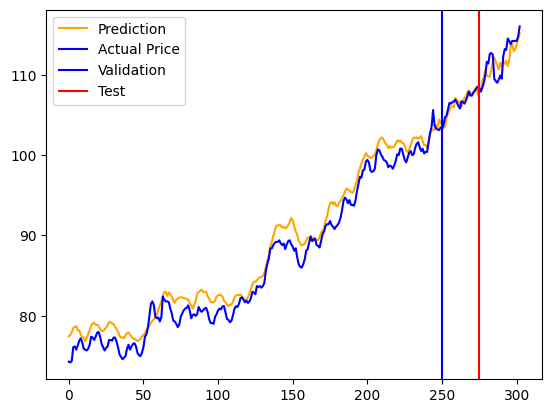

In [ ]:
plt.plot(train_results['Train Predictions'],label='Prediction', color = "orange")
plt.plot(train_results['Actuals'],label='Actual Price', color = "b")
plt.plot(np.arange(len(val_results))+len(train_results),val_results['Validation Predictions'],color = 'orange')
plt.plot(np.arange(len(val_results))+len(train_results),val_results['Actuals'], color = "b")
plt.plot(np.arange(len(test_results))+len(train_results)+len(val_results),test_results['Test Predictions'], color = "orange")
plt.plot(np.arange(len(test_results))+len(train_results)+len(val_results),test_results['Actuals'],color = "b")
plt.axvline(x = 250, color = 'b', label = 'Validation')
plt.axvline(x = 275, color = 'r', label = 'Test')
plt.legend()
plt.legend()

print(f"Training-MAPE {tf.keras.metrics.mean_absolute_percentage_error(train_results['Train Predictions'],train_results['Actuals'])}")
print(f"Validation-MAPE {tf.keras.metrics.mean_absolute_percentage_error(val_results['Validation Predictions'],val_results['Actuals'])}")
print(f"Test-MAPE {tf.keras.metrics.mean_absolute_percentage_error(test_results['Test Predictions'],test_results['Actuals'])}")


### Training Data-Set isolierte Ansicht

In [148]:
train_predictions = model3.predict(X_train).flatten() #Preis-Vorhersagen des Trainingsets

#Dictionary mit Preis-Vorhersagen und tatsächlichen Preisen des Trainingsets
train_results = pd.DataFrame(data={'Train Predictions':train_predictions,'Actuals': y_train}) 
train_results

tf.keras.metrics.mean_absolute_percentage_error(train_results['Train Predictions'],train_results['Actuals'])  #Mean Absolute percentage Error

8/8 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=1.8195974>

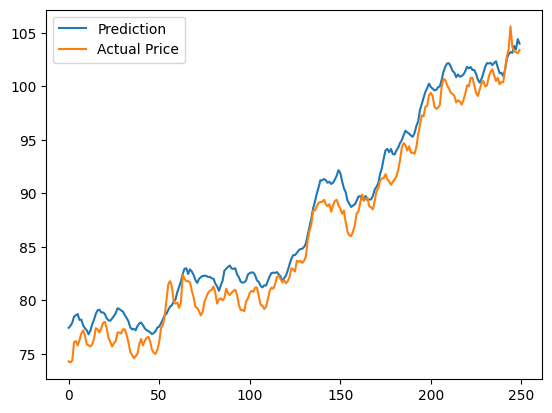

In [149]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'],label='Prediction')
plt.plot(train_results['Actuals'],label='Actual Price')
plt.legend()



### Validation Data-Set islolierte Ansicht

In [158]:
val_predictions = model3.predict(X_val).flatten() #Preis-Vorhersagen des Trainingsets

#Dictionary mit Preis-Vorhersagen und tatsächlichen Preisen des Trainingsets
val_results = pd.DataFrame(data={'Validation Predictions':val_predictions,'Actuals': y_val}) 
val_results

tf.keras.metrics.mean_absolute_percentage_error(val_results['Validation Predictions'],val_results['Actuals'])

1/1 [==============================] - 0s 19ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.4241203>

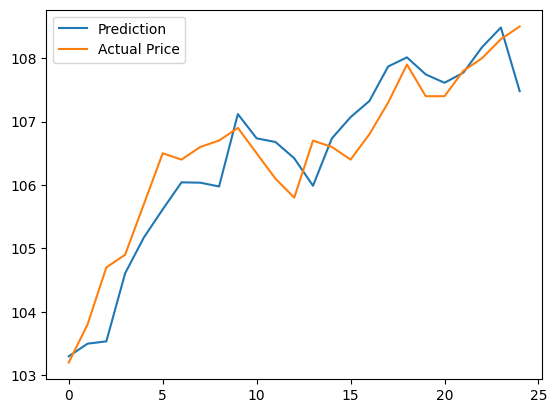

In [159]:
plt.plot(val_results['Validation Predictions'],label='Prediction')
plt.plot(val_results['Actuals'],label='Actual Price')
plt.legend()


### Test Data-Set isolierte Ansicht

In [161]:
test_predictions = model3.predict(X_test).flatten() #Preis-Vorhersagen des Trainingsets

#Dictionary mit Preis-Vorhersagen und tatsächlichen Preisen des Trainingsets
test_results = pd.DataFrame(data={'Test Predictions':test_predictions,'Actuals': y_test}) 
test_results

tf.keras.metrics.mean_absolute_percentage_error(test_results['Test Predictions'],test_results['Actuals'])

1/1 [==============================] - 0s 20ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=1.2147297>

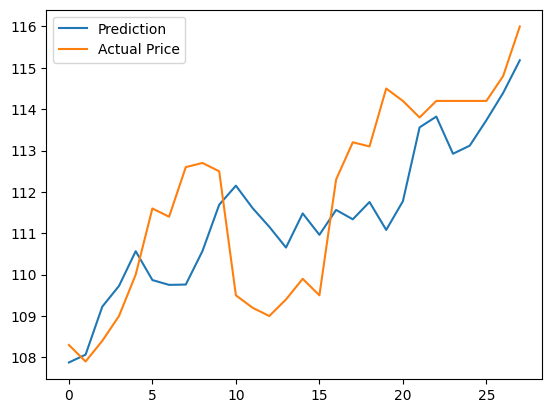

In [162]:
plt.plot(test_results['Test Predictions'],label='Prediction')
plt.plot(test_results['Actuals'],label='Actual Price')
plt.legend()
